# Homework 5

In this homework, you'll review some linear algebra, and practice using `sklearn` and `scipy.optimize` to solve several variations of linear models.  You'll also use Pandas and Scikit learn for a simple machine learning task on a UCI data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
import sklearn
import scipy.optimize as opt
import scipy.sparse as sparse
import sklearn.linear_model
import sklearn.model_selection

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but we'll use Householder notation by replacing $\beta$ with `b`
```
y = X * b + eps
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features.  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  Our goal is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (30 points)

There are a variety of ways to solve the above problem.  We'll assume that $n > p$, meaning there are more observations than features.

### Generating Data

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well.


In [2]:
def gen_lstsq(n, p, sig=0.1):
    '''
    Generate a linear least squares problem.
    '''
    X = np.random.randn(n,p)
    b = np.random.randn(p,1)
    eps = sig * np.random.randn(n,1)
    y = np.dot(X, b) + eps
    
    return X, y, b

### QR factorization

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above.

In [3]:
def solve_lstsq_qr(X, y):
    '''
    Use QR factorization to solve the linear regression problem.
    '''
    Q, R = la.qr(X, mode='economic')
    bhat = la.solve_triangular(R, Q.T @ y, lower = False)
    
    return bhat

### Normal Equations

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above.  You probably don't want to form the inverse - use an LU or Cholesky factorization instead.

In [4]:
def solve_lstsq_normal(X, y):
    '''
    Use normal equation to solve the linear regression problem.
    '''
    P,L,U = la.lu(X.T @ X)
    bhat = la.solve_triangular(U,
            la.solve_triangular(L,
                P.T @ X.T @ y,
                lower=True),
            lower=False)  # LU decomposition to solve the linear system.
    
    return bhat

### Check Your Work

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

In [5]:
X, y, b = gen_lstsq(1000, 5)
bhat_qr = solve_lstsq_qr(X, y)
bhat_normal = solve_lstsq_normal(X, y)
bhat = la.lstsq(X, y)[0]

diff1 = la.norm(bhat_qr-bhat_normal)
diff2 = la.norm(bhat-bhat_qr)
diff3 = la.norm(bhat-bhat_normal)

print(f"Difference between beta_qr and beta_normal is {diff1}")
print(f"The difference is smaller than 1e-4 is {diff1<1e-4}")
print(f"Difference between bhat from solve_lstsq and beta_qr is {diff2}")
print(f"The difference is smaller than 1e-4 is {diff2<1e-4}")
print(f"Difference between bhat from solve_lstsq and beta_normal is {diff3}")
print(f"The difference is smaller than 1e-4 is {diff3<1e-4}")

Difference between beta_qr and beta_normal is 6.473657049138938e-16
The difference is smaller than 1e-4 is True
Difference between bhat from solve_lstsq and beta_qr is 6.977643512971218e-16
The difference is smaller than 1e-4 is True
Difference between bhat from solve_lstsq and beta_normal is 7.731808680624463e-16
The difference is smaller than 1e-4 is True


### Estimate the Mean Squared Error

Write a function `mse` which estimates the mean squared error (MSE) $\mathbb{E}[\|X * \hat{b} - y\|_2^2]$.

The function should have the call signature `mse(b, bhat, N=100, sig=0.1)`  You can generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)` (use the same value of `sig` that you use when generating the data).  You can then estimate the MSE by computing $\frac{1}{N}\|X * \hat{b} - y\|_2^2$

Create a plot of the MSE vs the noise parameter `sig` (use the same value of `sig` when generating data and computing the MSE).  Put `sig` on a logartihmic axis ranging from `1e-4` to `10`.  Use `n=100`, `p=50` when generating data, and `N=100` when computing the MSE.  Put your plot on log-log axes.  Give it a title and axis labels.

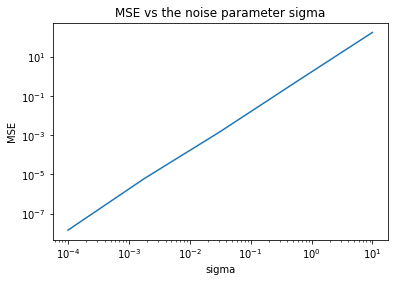

In [6]:
n = 100; p =50

def mse(b, bhat, N=100, sig=0.1):
    
    X = np.random.randn(N,p)
    y = X @ b + sig * np.random.randn(N,1)
    y_pred = X @ bhat
    mse = np.square(la.norm(y-y_pred))/N
    
    return mse

mse_list = list()
sig_range = np.logspace(-4, 1, num=5)
    
for i in sig_range:
    # generate data
    X, y, b = gen_lstsq(n, p, sig=i)
    
    # estimate beta
    bhat = solve_lstsq_normal(X, y)
    
    # calculate mse
    mse_n = mse(b, bhat, sig=i)
    mse_list.append(mse_n)

plt.loglog(sig_range, mse_list)
plt.xlabel("sigma")
plt.ylabel("MSE")
plt.title("MSE vs the noise parameter sigma")
plt.show()

### Discussion 1

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations).

In [7]:
X, y, b = gen_lstsq(n=100, p=50)
%time bhat1 = solve_lstsq_qr(X, y)
%time bhat2 = solve_lstsq_normal(X, y)

CPU times: user 2.56 ms, sys: 1.43 ms, total: 3.98 ms
Wall time: 5.15 ms
CPU times: user 1.62 ms, sys: 369 µs, total: 1.99 ms
Wall time: 1.06 ms


---

**MY DISCUSSION**

`solve_lstsq_normal` is faster than `solve_lstsq_qr`, but asympotically they are similar.

First, consider `solve_lstsq_normal`, it takes $O(p^2n)$ for multiplication $X^TX$ and $O(pn)$ for multiplication $X^Ty$. Then, for the LU decomposition of $X^TX$, it takes $O(p^3)$. To solve the linear system in the triangular form, the time is $O(p^2)$.

Therefore, the asympotic time using `solve_lstsq_normal` is $O(p^2n) + O(p^3)$

Second, consider `solve_lstsq_qr`, it takes $O(p^2n)$ for QR decomposition and $O(pn)$ for multiplication $Q^Ty$. Then, to solve the linear system in the triangular form, the time is $O(p^2)$.

Therefore, the asympotic time using `solve_lstsq_normal` is $O(p^2n)$

Asymptotically, since we generally have $n>p$, $O(p^3)$ is dominated by $O(p^2n)$ and therefore, they are similar.

However, since the LU decomposition is twice as fast as the QR decomposition. `solve_lstsq_normal` can be also faster than `solve_lstsq_qr`.

### Optimization

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) = \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [8]:
def solve_lstsq_opt(X, y):
    '''
    Use the minimization to solve the linear regression problem.
    '''
    n, p = X.shape
    
    def f(b):
        f = b.T @ X.T @ X @ b - 2 * y.T @ X @ b + y.T @ y
        return f.flatten()
    
    def J(b):
        J = 2 * b.T @ X.T @ X - 2 * y.T @ X # 2/n*(b^T(X^TX)-y^TX)
        return J.flatten()
    
    bhat = opt.minimize(f, np.zeros((p,1)), jac = J)['x'].reshape(p,1)
                        
    return bhat

#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

In [9]:
n = 100; p = 50
X, y, b  = gen_lstsq(n, p)
bhat_opt = solve_lstsq_opt(X, y)
bhat_qr  = solve_lstsq_qr(X, y)
bhat_normal = solve_lstsq_normal(X, y)

diff1 = la.norm(bhat_opt-bhat_qr)
diff2 = la.norm(bhat_opt-bhat_normal)
print(f"Difference between solve_lstsq_opt and solve_lstsq_qr is {diff1}")
print(f"The difference is smaller than 1e-4 is {diff1<1e-4}")
print(f"Difference between solve_lstsq_opt and solve_lstsq_normal is {diff2}")
print(f"The difference is smaller than 1e-4 is {diff2<1e-4}")

Difference between solve_lstsq_opt and solve_lstsq_qr is 2.846367044456615e-08
The difference is smaller than 1e-4 is True
Difference between solve_lstsq_opt and solve_lstsq_normal is 2.846367185072235e-08
The difference is smaller than 1e-4 is True


### Discussion 2

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [10]:
X, y, b = gen_lstsq(n=100, p=50)
%time bhat1 = solve_lstsq_qr(X, y)
%time bhat2 = solve_lstsq_normal(X, y)
%time bhat3 = solve_lstsq_opt(X, y)

CPU times: user 1.71 ms, sys: 1.32 ms, total: 3.02 ms
Wall time: 4.04 ms
CPU times: user 1.13 ms, sys: 254 µs, total: 1.38 ms
Wall time: 1.22 ms
CPU times: user 39.8 ms, sys: 1.71 ms, total: 41.5 ms
Wall time: 32.1 ms


---
**My Discussion**
`solve_lstsq_opt` is much slower than `solve_lstsq_qr` and `solve_lstsq_normal`.

The reason is that the minimization problem is  doing iteration, which repeats matrix multiplication and costs much more time than solve the linear system directly.

### Scikit Learn

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to solve the linear regression problem. You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `LinearRegression` instead of a `solve_lstsq` function.  Set the keyword `fit_intercept=False`.

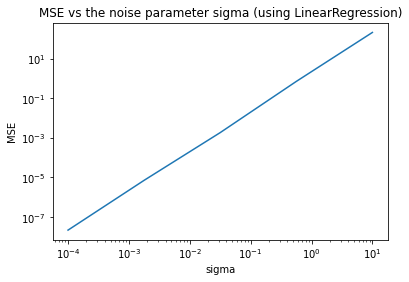

In [11]:
n = 100; p =50
mse_list = list()
sig_range = np.logspace(-4, 1, num=5)
    
for i in sig_range:
    # generate data
    X, y, b = gen_lstsq(n, p, sig=i)
    
    # estimate beta
    reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(X, y)
    bhat = reg.coef_.T
    
    # calculate mse
    mse_n = mse(b, bhat, sig=i)
    
    mse_list.append(mse_n)
    
plt.loglog(sig_range, mse_list)
plt.xlabel("sigma")
plt.ylabel("MSE")
plt.title("MSE vs the noise parameter sigma (using LinearRegression)")
plt.show()

## Problem 1 - Ridge Regression (15 points)

We'll now turn to the problem of what to do when `n < p` (there are fewer observations than features).  In this case we can solve $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

The normal equations are singular, and the $R$ term of the QR factorization is not invertible in this case.  We need to do something else.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Optimization

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---

The Jacobian is  $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^TX + \frac{2}{n}\lambda b^T$

In [12]:
def solve_ridge_opt(X, y, lam=0.1):
    '''
    Use the minimization to solve the ridge regression problem.
    '''
    n, p = X.shape
    
    def f(b):
        f = b.T @ X.T @ X @ b - 2 * y.T @ X @ b + y.T @ y + lam * b.T @ b
        return f.flatten()
    
    def J(b):
        J = 2 * b.T @ X.T @ X - 2 * y.T @ X + 2 * lam * b.T 
        return J.flatten()
    
    bhat = opt.minimize(f, np.zeros((p,1)), jac = J)['x'].reshape(p,1)
                        
    return bhat

### Compute the MSE

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the MSE of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

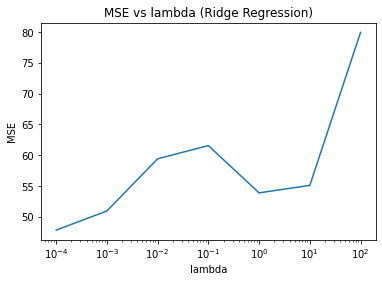

In [13]:
n =50; p = 100
mse_list = list()
lam_range = np.logspace(-4, 2, num=7)

# generate data
X, y, b = gen_lstsq(n, p)
    
for i in lam_range:
    
    # estimate beta
    bhat = solve_ridge_opt(X, y, lam=i)
    
    # calculate mse
    mse_n = mse(b, bhat)
    
    mse_list.append(mse_n)
    
plt.semilogx(lam_range, mse_list)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.title("MSE vs lambda (Ridge Regression)")
plt.show()

### Scikit Learn

Use [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to solve the Ridge regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Ridge` instead of your `solve_ridge_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

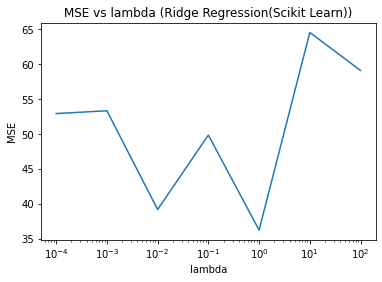

In [14]:
n = 50; p = 100
mse_list = list()
lam_range = np.logspace(-4, 2, num=7)

# generate data
X, y, b = gen_lstsq(n, p)
    
for i in lam_range:
    
    # estimate beta
    ridge = sklearn.linear_model.Ridge(alpha=i, fit_intercept=False).fit(X, y)
    bhat = ridge.coef_.T
    
    # calculate mse
    mse_n = mse(b, bhat)
    
    mse_list.append(mse_n)
    
plt.semilogx(lam_range, mse_list)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.title("MSE vs lambda (Ridge Regression(Scikit Learn))")
plt.show()

## Problem 2 - Lasso (15 points)

The Lasso is L1-regularized regression.  This is often used when `p > n`, and when the parameter vector `b` is assumed to be sparse, meaning that it has few non-zero entries.

The minimization problem is
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Where again, $\lambda$ can be chosen.

### Generate Data

We need to modify our generation of data to produce sparse `b`.  Write a function `gen_lstsq_sparse(n, p, sig=0.1, k=10)`, which generates `X` and `y` in the same way as `gen_lstsq`, but now `b` is generated to be a vector of length `p` with `k` random entries set to 1, and all other entries set to 0. Hint: look at `np.random.choice` for generating `k` random integers without replacement.

In [15]:
def gen_lstsq_sparse(n, p, sig=0.1, k=10):
    '''
    generate a linear least squares problem in Lasso.
    '''
    # generate sparse b: length p with k random entries set to 1.
    row = np.random.choice(p, k)
    col = np.zeros(k)
    data = np.ones(k)
    b = sparse.coo_matrix((data, (row,col)), shape=(p,1)).tocsc()
    
    X = np.random.randn(n,p)
    eps = sig * np.random.randn(n,1)
    y = X @ b + eps
    
    return X, y, b

### Optimization

Recall we want to find `bhat` to solve
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_lasso_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_1 = \lambda \sum_i |b_i|
\end{equation}

If $b_i$ is zero, then take $\partial_i |b_i| = 0$ (this is in the [subgradient](https://en.wikipedia.org/wiki/Subderivative)). Hint 2: look at `np.sign` for implementation

---

The Jacobian is  $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^TX + \frac{1}{n}\lambda \times sgn(b^T)$

In [16]:
def solve_lasso_opt(X, y, lam=0.1):
    '''
    Solve Lasso using minimization problem.
    '''
    n, p = X.shape
    def f(b):
        f = b.T @ X.T @ X @ b - 2 * y.T @ X @ b + y.T @ y + lam * la.norm(b, ord=1)
        return f.flatten()
    
    def J(b):
        J = 2 * b.T @ X.T @ X - 2 * y.T @ X + lam * np.sign(b).reshape(1,p)
        return J.flatten()
    
    bhat = opt.minimize(f, np.zeros((p,1)), jac = J)['x'].reshape(p,1)
    
    return bhat

### Compute the MSE

Set `n = 50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  Make a plot that displays the MSE of `bhat` computed using `solve_lasso_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

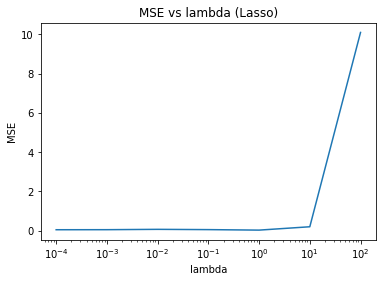

In [17]:
n = 50; p = 100

mse_list= list()
lam_range = np.logspace(-4, 2, num=7)

# generate data
X, y, b = gen_lstsq_sparse(n, p)

for i in lam_range:
    
    # estimate beta
    bhat = solve_lasso_opt(X, y, lam=i)
    
    # calculate mse
    mse_n = mse(b, bhat)
    mse_list.append(mse_n)
    
plt.semilogx(lam_range, mse_list)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.title("MSE vs lambda (Lasso)")
plt.show()

### Scikit Learn

Use [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) to solve the Lasso regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Lasso` instead of your `solve_lasso_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

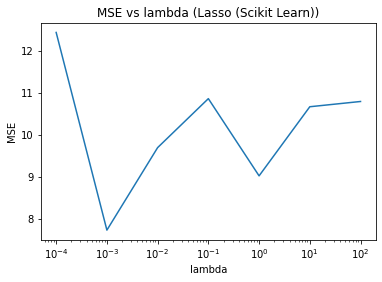

In [18]:
n = 50; p=100

mse_list= list()
lam_range = np.logspace(-4, 2, num=7)

# generate data
X, y, b = gen_lstsq_sparse(n, p)

for i in lam_range:
    
    # estimate beta
    lasso = sklearn.linear_model.Lasso(alpha=i, fit_intercept=False, max_iter=3000).fit(X, y)
    bhat1 = lasso.coef_.T
    
    # calculate mse
    mse_n = mse(b, bhat)
    mse_list.append(mse_n)
    
plt.semilogx(lam_range, mse_list)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.title("MSE vs lambda (Lasso (Scikit Learn))")
plt.show()

## Problem 3 - Elastic Net (20 points)

Another option when `p > n` is the [Elastic Net]() which combines L1 and L2 regularization.

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda_1 \|b\|_1 + \lambda_2 \|b\|_2^2
\end{equation}
Where we get to choose $\lambda_1$ and $\lambda_2$.

You can find a function that does this in [`sklearn.linear_model.ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

In this problem, you'll write a class that emulates the behavior of a Scikit learn class. Use `scipy.optimize.minimize` to solve the optimization problem.


### Jacobian

Give an expression for the Jacobian for the optimization objective function.  You've already done all the hard work for this in problems 1 and 2

---

The Jacobian is  $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^TX + \frac{1}{n}\lambda_1 \times sgn(b^T) + \frac{2}{n}\lambda_2 b^T$

### Write the Class

Define a Python Class `ElasticNet`.  When you initialize the class you should be able to provide keyword arguments `lam1` for $\lambda_1$ and `lam2` for $\lambda_2$.  Give each these keyword arguments a default value of `0.5`.

In addition to `__init__`, your class should provide two methods:
1. `fit(X, y)` - sets an attribute `bhat` which solves the optimization problem (use the parameters `lam1` and `lam2` provided in initialization).  Use `scipy.optimize.minimize`
2. `predict(X)` - predict values of `y` as `X @ bhat`

In [19]:
class ElasticNet:
    
    def __init__(self, lam1=0.5, lam2=0.5):
        self.lam1 = lam1
        self.lam2 = lam2
        self.bhat = None
        
    def fit(self, X, y):
        
        n, p = X.shape
        
        def f(b):
            f = b.T @ X.T @ X @ b - 2 * y.T @ X @ b + y.T @ y + self.lam1 * la.norm(b, ord=1) + self.lam2 * b.T @ b
            return f.flatten()
    
        def J(b):
            J = 2 * b.T @ X.T @ X - 2 * y.T @ X + self.lam1 * np.sign(b).reshape(1,p) + self.lam2 * b.T
            return J.flatten()
        
        self.bhat = opt.minimize(f, np.zeros((p,1)), jac = J)['x'].reshape(p,1)
        
    def predict(self, X):
        
        return X @ self.bhat

### Compute the MSE

Set `n=50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  

Set `n=50`, `p=100`, and `sig=0.1` to generate a problem using `gen_lstsq`.

Make a plot that displays the MSE of the model computed using your `ElasticNet` class using `lam1=lam2` varying between `1e-4` and `1e2` for each of the generated problems (your plot should have 2 lines).  Give your plot a title, axis labels, and a legend.

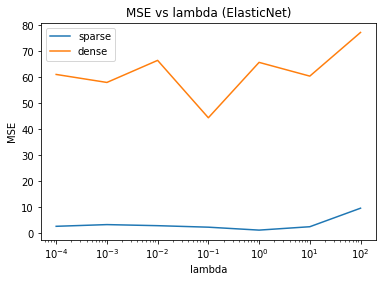

In [20]:
n = 50; p = 100
lam_range = np.logspace(-4, 2, num=7)
mse_list1= list()
X, y, b = gen_lstsq_sparse(n, p)

for i in lam_range:
    elnet = ElasticNet(lam1=i, lam2=i)
    elnet.fit(X, y)
    bhat = elnet.bhat
    mse_n = mse(b, bhat)
    mse_list1.append(mse_n)

mse_list2= list()
X, y, b = gen_lstsq(n, p)

for i in lam_range:
    elnet = ElasticNet(lam1=i, lam2=i)
    elnet.fit(X, y)
    bhat = elnet.bhat
    mse_n = mse(b, bhat)
    mse_list2.append(mse_n)
    
plt.semilogx(lam_range, mse_list1, label="sparse")
plt.semilogx(lam_range, mse_list2, label="dense")
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(loc='best')
plt.title("MSE vs lambda (ElasticNet)")
plt.show()

## Problem 4 - Real Data (20 points)

In this problem you'll use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/).  We'll focus on the red wines found in [`winequality-red.csv`](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv).  The goal is to train a machine learning model that will predict the wine quality from a variety of other features.

### Load the data set

Load the wines in `winequality-red.csv` into a Pandas data frame. Note that this file has column labels, which are interpreted in the data set documentation:

Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

Note that this file uses semi-colons `;` to delimit values.  You can use `delimiter=';'` as a keyword argument.

In [22]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                  delimiter=';')
X = data.iloc[:,:-1]
y = data['quality']

The first 11 columns will be features for the model (used in the design matrix `X`), and the last column (quality) is the quantity we're tyring to predict (the response `y`).

### Split the Data in to Training and Testing Sets

Split the data `X, y` into `X_train, y_train, X_test, y_test` using `sklearn`.  Use 70% of the data for training, and 30% of the data for testing.


In [23]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

### Train a Model and Measure Error

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to fit a linear regression model to your training data.

Use [`sklearn.metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) to compute the MSE on your test set.

In [24]:
# fit a linear regression model to your training data
model = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

# predict y using training model
y_pred = model.predict(X_test)

# compute the MSE on your test set
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print(f"MSE on the test set is {mse}")

MSE on the test set is 0.41123487175041995
